# HW 2 PyTourch

In [1]:
import torch
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from matplotlib import cm
import pandas as pd
import tqdm.notebook as tqdm

## Формирование dataset

In [3]:
torch.manual_seed(42)

def func(x,y):
    return torch.sin(x+2*y)*torch.exp(-(2*x+y)**2)

def generate_data(num_samples):
    x = torch.rand(num_samples, 1) * 20 - 10
    y = torch.rand(num_samples, 1) * 20 - 10
    z = func(x,y)
    return x, y, z


In [4]:
# 20000 точек (x,y) в диапазон значений [-10;10]
num_samples=20000
x, y, z = generate_data(num_samples)

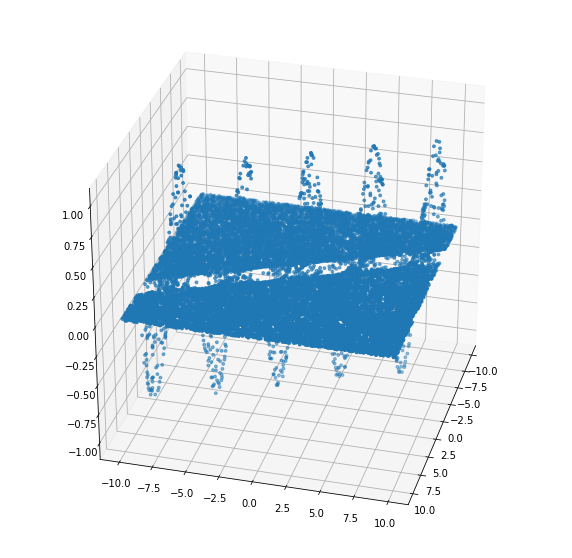

In [5]:
# Отображаем точки

fig = plt.figure(figsize = (10, 10))
ax = plt.axes(projection='3d')

ax.scatter(x, y, z, s=8);
ax.view_init(30, 15)

Отображаем точки на поверхности функции

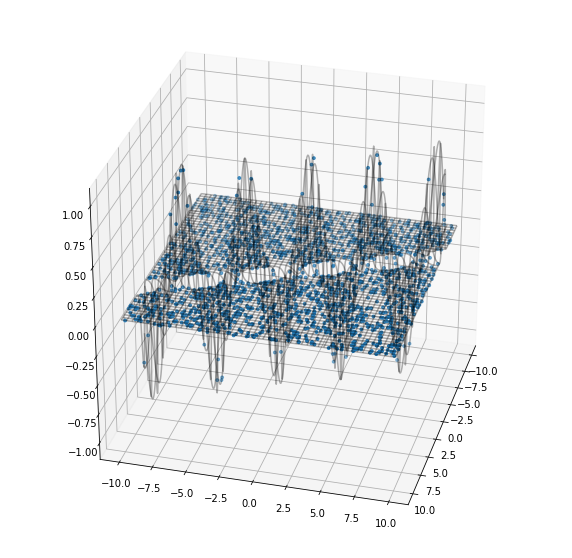

In [6]:
def make_data():
    x = np.arange(-10, 10, 0.05)
    y = np.arange(-10, 10, 0.05)
    xgrid, ygrid = np.meshgrid(x, y)

    z = np.sin(xgrid + 2 * ygrid) * np.exp(-(2 * xgrid + ygrid)**2)
    return xgrid, ygrid, z


if __name__ == '__main__':
    X, Y, Z = make_data()

    fig = plt.figure(figsize = (10, 10))
    ax = fig.add_subplot(projection='3d')

    ax.scatter3D(x[:2000], y[:2000], z[:2000], s = 8);
    ax.plot_wireframe(X, Y, Z, color='black', alpha=0.3)
    ax.view_init(30, 15)
    plt.show()

Создаем DataFrame

In [7]:
data = torch.concat([x,y,z]).reshape(3,num_samples).t()
numpy_data = data.numpy()
df = pd.DataFrame(numpy_data,columns=['x','y','z'])
df

,x,y,z
0,7.645386,3.040989,0.000000e+00
1,8.300079,-7.577096,-2.367854e-36
2,-2.342725,-5.490070,-1.401298e-45
3,9.186113,-8.930835,-1.318958e-39
4,-2.191036,-8.091998,0.000000e+00
...,...,...,...
19995,-0.416498,-9.345268,-0.000000e+00
19996,5.138516,-0.201555,-8.407791e-45
19997,-8.738790,8.425158,2.492262e-36
19998,1.758851,-8.004183,-1.801162e-09


Делим датасет на train/ test / val в отношениях 70% / 15% / 15%, соответственно

In [8]:
train, test, validate = np.split(df,[int(0.7*len(df)),int(0.85*len(df))])
print(f'train {train.shape[0]/df.shape[0]}')
print(f'test {test.shape[0]/df.shape[0]}')
print(f'validate {validate.shape[0]/df.shape[0]}')

train 0.7
test 0.15
validate 0.15


In [9]:
# Данные из DataFrame в Tensor
train = torch.FloatTensor(train.values)
test = torch.FloatTensor(test.values)
validate = torch.FloatTensor(validate.values)

x_train = train[:,:2]; y_train = train[:,2].squeeze()
x_test = test[:,:2]; y_test = test[:,2].squeeze()
x_val = validate[:,:2]; y_val = validate[:,2].squeeze()

print(x_train.size(),y_train.size(),x_test.size(),y_test.size(),x_val.size(),y_val.size())


torch.Size([14000, 2]) torch.Size([14000]) torch.Size([3000, 2]) torch.Size([3000]) torch.Size([3000, 2]) torch.Size([3000])


### Модель

Модель состоит из 3 линейных слоев и 2 функций активации ReLU для добавления нелинейности

In [10]:
class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.line1 = torch.nn.Linear(2, 128)
        self.act1 = torch.nn.ReLU()
        self.line2 = torch.nn.Linear(128, 64)
        self.act2 = torch.nn.ReLU()
        self.line3 = torch.nn.Linear(64, 1)
    def forward(self, x):
        x = self.line1(x)
        x = self.act1(x)
        x = self.line2(x)
        x = self.act2(x)
        x = self.line3(x)
        return x

''' Define device and model '''

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

model = Net().to(device)

Using cpu device


### Тренируем модель

Используем оптимизатор Adam c learning rate = 0.001 и функцию потерь MSELoss

In [11]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = torch.nn.MSELoss()

In [12]:
# Обучаем модель

for epoch_index in tqdm.tqdm(range(10000+1)):
    # для ускорения используем случайный mini-batch (размером 1000)
    ix = torch.randint(0, x_train.shape[0], size=(1000,))

    # делаем предсказание
    y_pred = model(x_train[ix])
    

    # MSE loss
    loss = loss_fn(y_pred.squeeze(), y_train[ix])
   
   # if loss.item()<=0.0005:
   #     print(f'Last Epoch [{epoch_index}], Loss: {loss.item():.4f}')
   #     break
    if epoch_index % 1000 == 0:
        print(f'Epoch [{epoch_index}], Loss: {loss.item():.6f}')
        
    optimizer.zero_grad() 
    loss.backward()  
    optimizer.step()
    

Epoch [0], Loss: 0.491445
Epoch [1000], Loss: 0.014137
Epoch [2000], Loss: 0.012184
Epoch [3000], Loss: 0.017371
Epoch [4000], Loss: 0.006523
Epoch [5000], Loss: 0.007725
Epoch [6000], Loss: 0.003768
Epoch [7000], Loss: 0.001358
Epoch [8000], Loss: 0.002431
Epoch [9000], Loss: 0.001601
Epoch [10000], Loss: 0.001566



### Проверка модели

Оценка модели

In [17]:
y_pred = model(x_test)

mse_loss = loss_fn(y_pred.squeeze(), y_test)
print(f'mse: {mse_loss}')

mse: 0.001467440277338028


Отображение графиков истинных и предсказанных данных на валидационной выборке

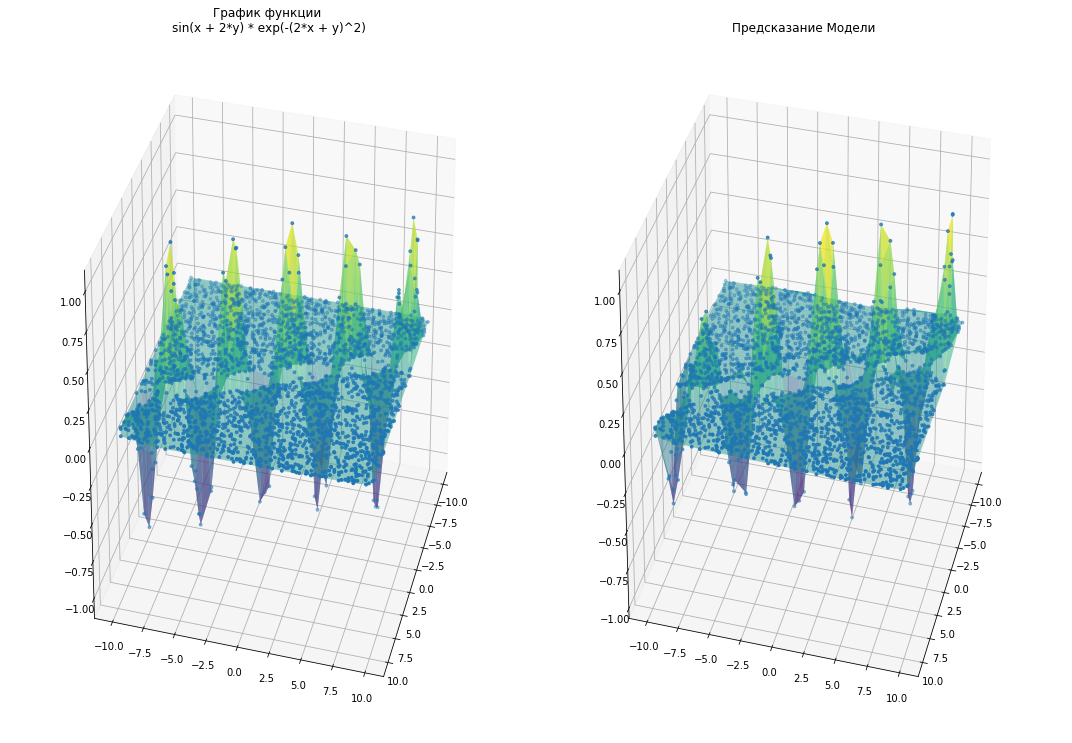

In [13]:
fig, axes = plt.subplots(1, 2, subplot_kw={'projection': '3d'}, figsize=(15,10))
fig.tight_layout(h_pad=5)   
    
Z = model(x_val)
    

axes[0].plot_trisurf(x_val[:,0].numpy(), x_val[:,1].numpy(), y_val.numpy(), cmap='viridis',alpha=0.5)
axes[0].scatter(x_val[:,0].numpy(), x_val[:,1].numpy(), y_val.numpy(),s=8)
axes[1].plot_trisurf(x_val[:,0].numpy(), x_val[:,1].numpy(), Z.squeeze(1).detach().numpy(),cmap='viridis', alpha=0.5)
axes[1].scatter(x_val[:,0].numpy(), x_val[:,1].numpy(), Z.squeeze(1).detach().numpy(),s=8)
axes[0].set_title('График функции \nsin(x + 2*y) * exp(-(2*x + y)^2)')
axes[1].set_title('Предсказание Модели')
axes[0].view_init(30, 15)
axes[1].view_init(30, 15)

    


## Выводы

С помощью библиотеки PyTorch была аппроксимирована сложная функция.

Для ускорения обучения использовались случайные мини-батчи для каждой эпохи, что позволило провести обучение на cpu